# Steric sea level change in the North East Atlantic

Computed using EN4 and IAP data sets and the gsw package (https://github.com/TEOS-10/GSW-Python)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
import importlib
import sys
sys.path.append('../code')
import SeaLevelContrib as slc

import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [2]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/sbult/Desktop/Scripts/SeaLevelContrib.py'>

In [4]:
data_path = '../Scripts/data/StericDataSterre/DataSteric/'
data_EN4 = data_path + 'density_teos10_EN421f_analysis_g10/'
data_IAP = data_path + 'DataStericIAP/'
data_TS_IAP = data_path + 'DataTS_IAP/'
data_steric3D_IAP = data_path + 'density_teos10_IAP/'

In [5]:
def pearson_r_3D(ts,slab,anom=True):
    """
    Compute a 2D field of correlation coefficients,
    given a 1D-timeseries ('ts') and a 3D-field ('slab')
    """
    # compute anomalies if neccessary
    if not anom:
        ts = ts - np.nanmean(ts)
        slab = slab - np.expand_dims(np.nanmean(slab,axis=0),0)
    # 'ts' to match 3D shape of 'slab'
    ts_3D = np.rollaxis(np.rollaxis(np.reshape(
        np.tile(ts,slab.shape[1]*slab.shape[2]), 
        (slab.shape[2],slab.shape[1],len(ts))),2,0),2,1)
    # standard deviations
    ts_3D_slab_cov = np.nansum(ts_3D*slab,axis=0)
    ts_3D_stdev = np.sqrt(np.nansum(np.power(ts_3D,2),axis=0))
    slab_stdev = np.sqrt(np.nansum(np.power(slab,2),axis=0))
    # pearson correlation
    pearson = ts_3D_slab_cov / (ts_3D_stdev * slab_stdev)
    # done
    return pearson

## Explore the EN4 data over different integration depths and reference periods

In [6]:
DENS = xr.open_dataset(f'{data_path}density_teos10_en422_g10_1900_2022.nc')
DENS.coords

Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -20.0 -19.0 -18.0 -17.0 -16.0 ... 17.0 18.0 19.0 20.0
  * time     (time) int64 1900 1901 1902 1903 1904 ... 2017 2018 2019 2020 2021

In [7]:
# Compute the thickness of each vertical layers
midp = (np.array(DENS.depth[1:])+np.array(DENS.depth[:-1]))/2
midp = np.insert(midp, 0, np.array([0]))
midp = np.insert(midp, len(midp), np.array(DENS.depth[-1]) + 
                 (np.array(DENS.depth[-1]) - np.array(DENS.depth[-2])))
thick = midp[1:] - midp[:-1]
thick = xr.DataArray(thick, coords={'depth': DENS.depth[:]}, dims='depth')

SumDens = DENS.density * thick

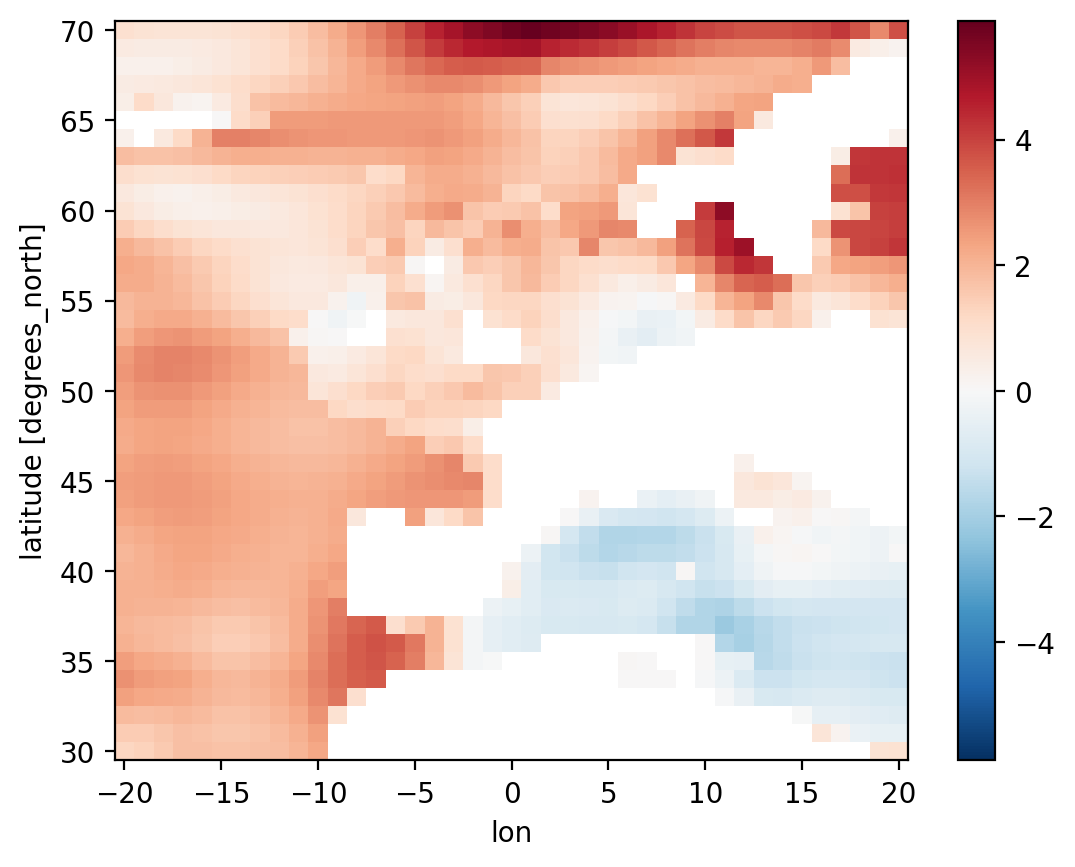

In [13]:
# Compute the steric sea level in cm for a given depth range
StericSL = (- SumDens.sel(depth=slice(0,500)).sum(dim='depth') 
            / DENS.density[0 ,0 ,: ,:]) * 100

# Compute the diference between two periods of time and plot
StericSL = StericSL - StericSL.sel(time=slice(1950,1970)).mean(dim='time')
StericSL.sel(time=slice(2000,2021)).mean(dim='time').plot()
plt.title('');

In [16]:
StericSL = StericSL.sel(time=slice(1950,2022))

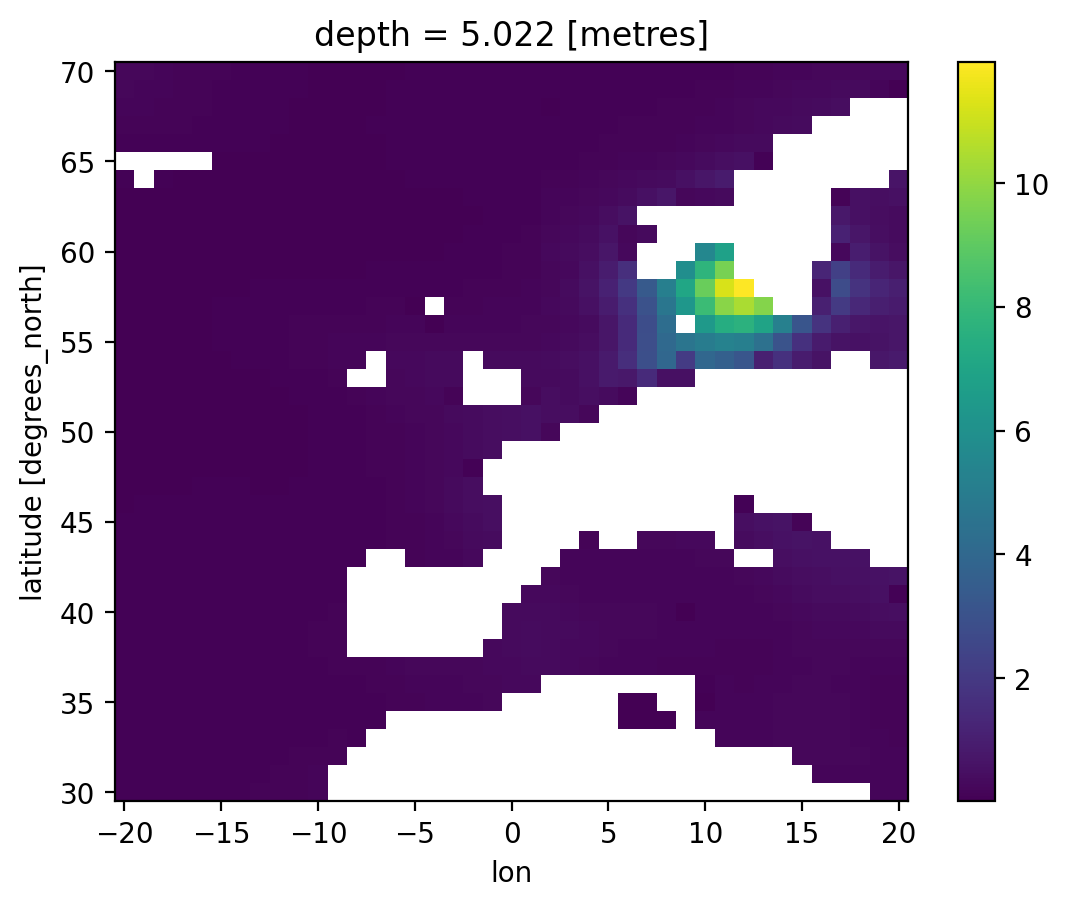

In [17]:
StericSLVar = StericSL.var(dim='time')
StericSLVar.plot()

## Compute the depth of the grid

AttributeError: 'QuadMesh' object has no attribute 'plot'

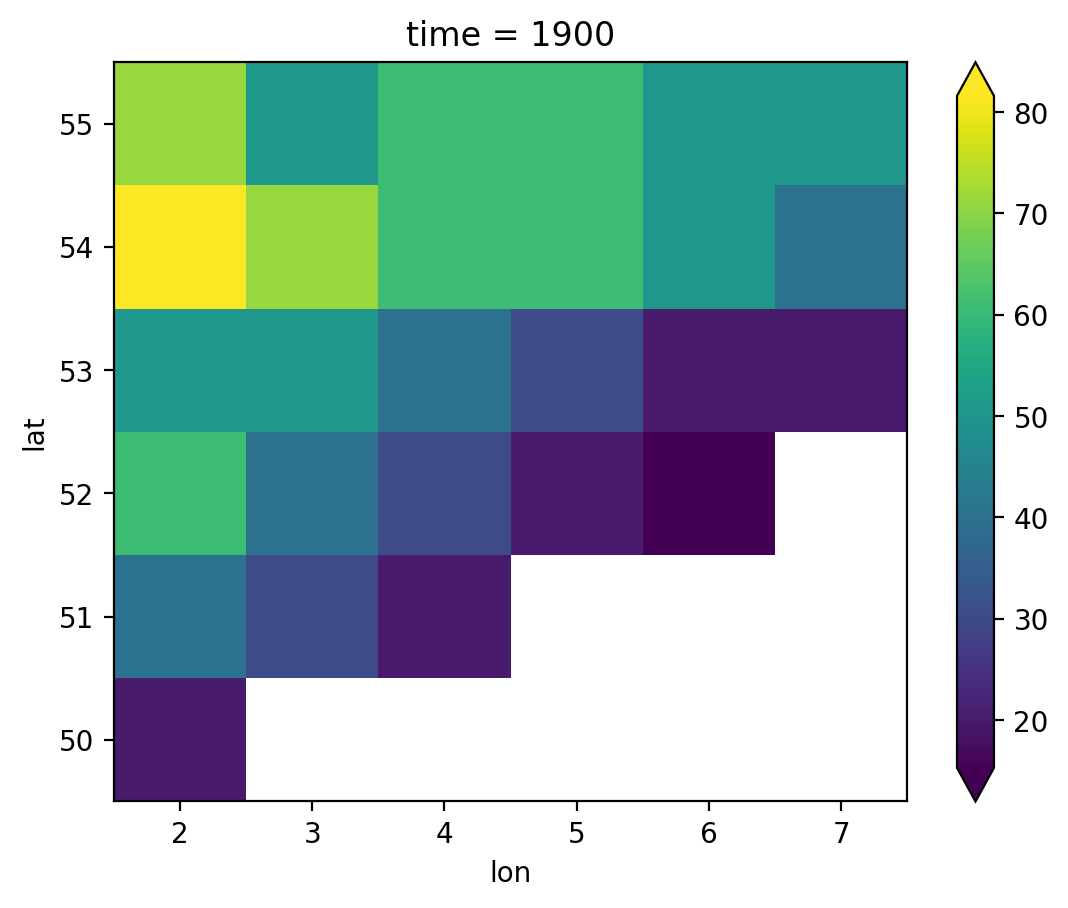

In [19]:
Ones = xr.where(np.isnan(DENS.density[0,:,:,:]), np.NaN, 1)
DepthAr = (Ones * thick).sum(axis=0)
DepthArSel = xr.where(DepthAr == 0, np.NaN, DepthAr)
DepthArSel.sel(lat=slice(50,55), lon=slice(2,7)).plot(robust=True).plot(robust=True)
#DepthAr.plot()

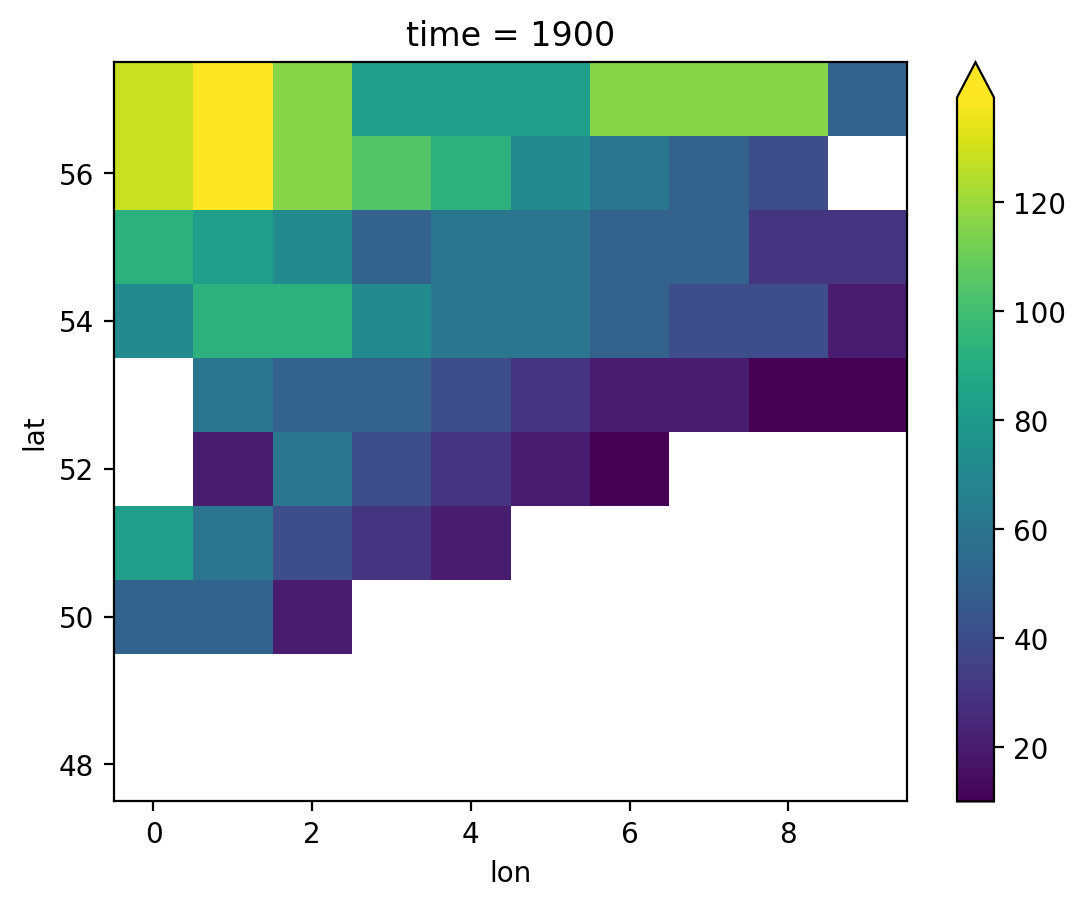

In [20]:
DepthArSel.sel(lat=slice(48,57), lon=slice(0,9)).plot(robust=True)

Idea: Use the same method as in Seltini et al. 2017? Average steric effect of deeper area to determine the local effect. For "surface" waters. Use a large area for deep water and an even larger area for bottom water.

## Check the correlation between sea level time series and steric sea level

Read the csv file of a sea level budget. Remove all known contrutors to sea level from the observations and check the residual.

In [96]:
b_df = pd.read_csv(f'../outputs/slbudget_2022_11_23_ZSM_tide_gauge_1950_2021_ERA5_StericEN4_22_[500, 4000]m.csv')
#b_df = pd.read_csv(f'../outputs/slbudget_2022_11_22_NL_region_altimetry_1993_2021_ERA5_StericIAP_2000m.csv')
#Projects/SLBudget/outputs/slbudget_2022_11_23_ZSM_tide_gauge_1950_2021_ERA5_StericEN4_22_[500, 4000]m.csv

b_df = b_df.set_index('time')

nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1)
diff_df = b_df.Obs - nt


/var/folders/4x/jddrv9056c3bmvydrhcmv4gw0000gn/T/ipykernel_18593/1674537067.py:19: RuntimeWarning: invalid value encountered in divide
  pearson = ts_3D_slab_cov / (ts_3D_stdev * slab_stdev)


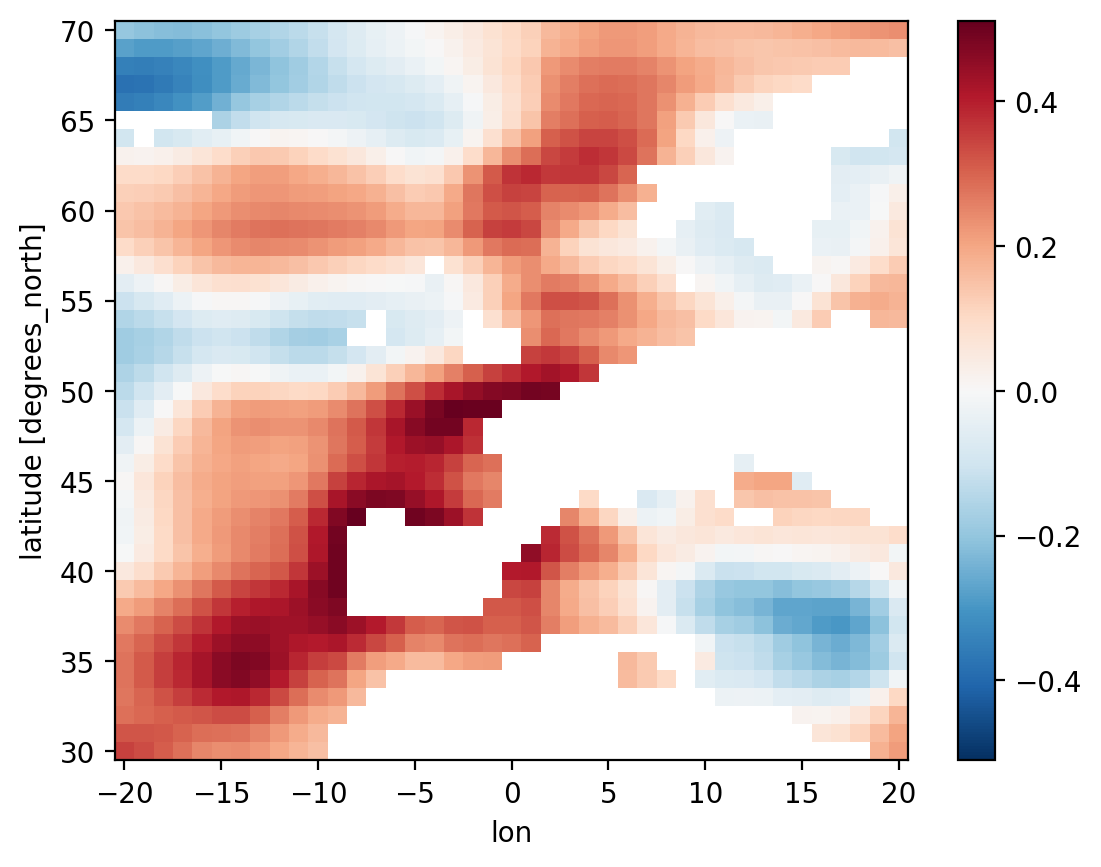

In [97]:
# Compute the correlation of the detrended data set, with a running mean of 3 years
StericSL_noNaN = xr.where(np.isnan(StericSL), 0, StericSL)

StericSLcor_dt = pearson_r_3D(signal.detrend(diff_df.iloc[1:-1]), 
                              signal.detrend( StericSL_noNaN.sel( time=slice( 1950, 2021)).rolling(time=3, center=True).mean().dropna('time'), axis=0)
                              , anom=False)

StericSLcor_dt = xr.DataArray(StericSLcor_dt, dims=['lat', 'lon'], 
                           coords={'lat' : StericSL.lat, 'lon' : StericSL.lon})
StericSLcor_dt.plot()

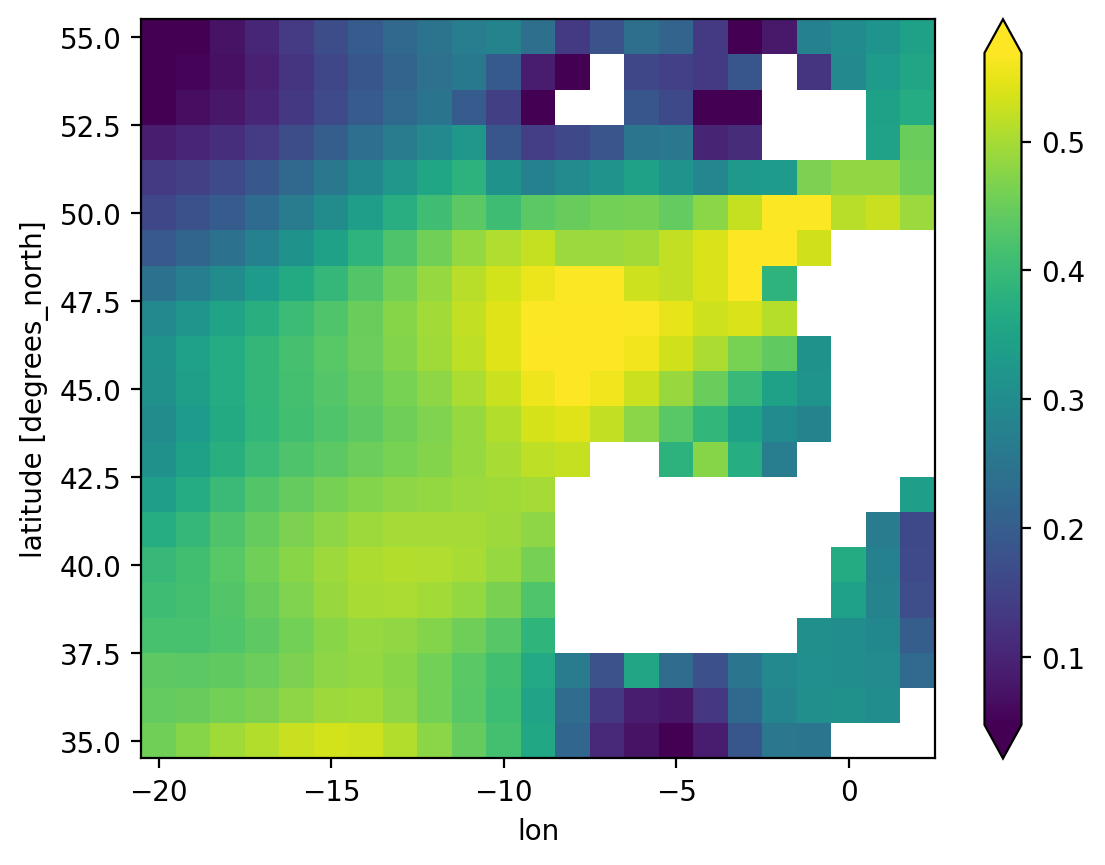

In [65]:
StericSLcor_dt.sel(lat=slice(35, 55), lon=slice(-20,2)).plot(robust=True)

The result depends a lot on the choice of the tide gauge even for the Dutch coast. Compare for example Vlissingen and Hoek van Holland.

### Plot a few region masks over which the steric effect can be computed

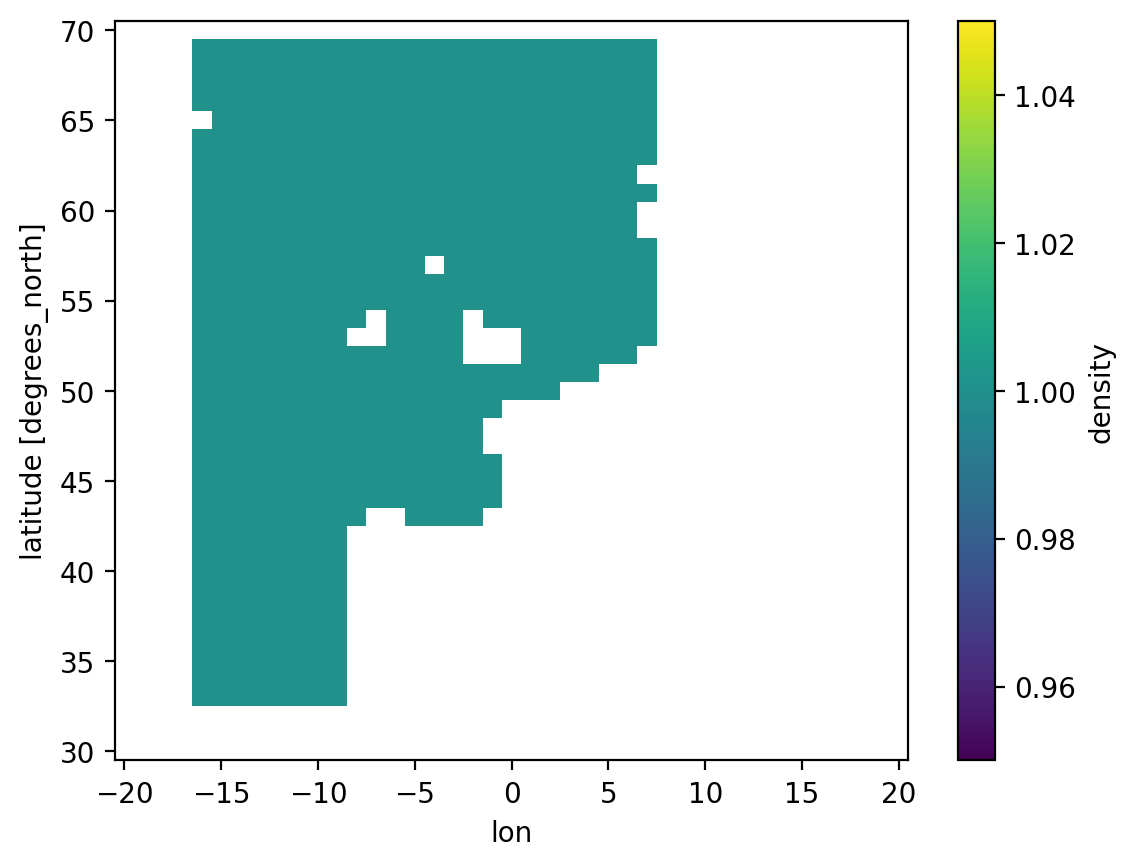

In [21]:
mask_ENS = slc.steric_masks_north_sea(DENS.density, 'ENS')
mask_ENS.plot()

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


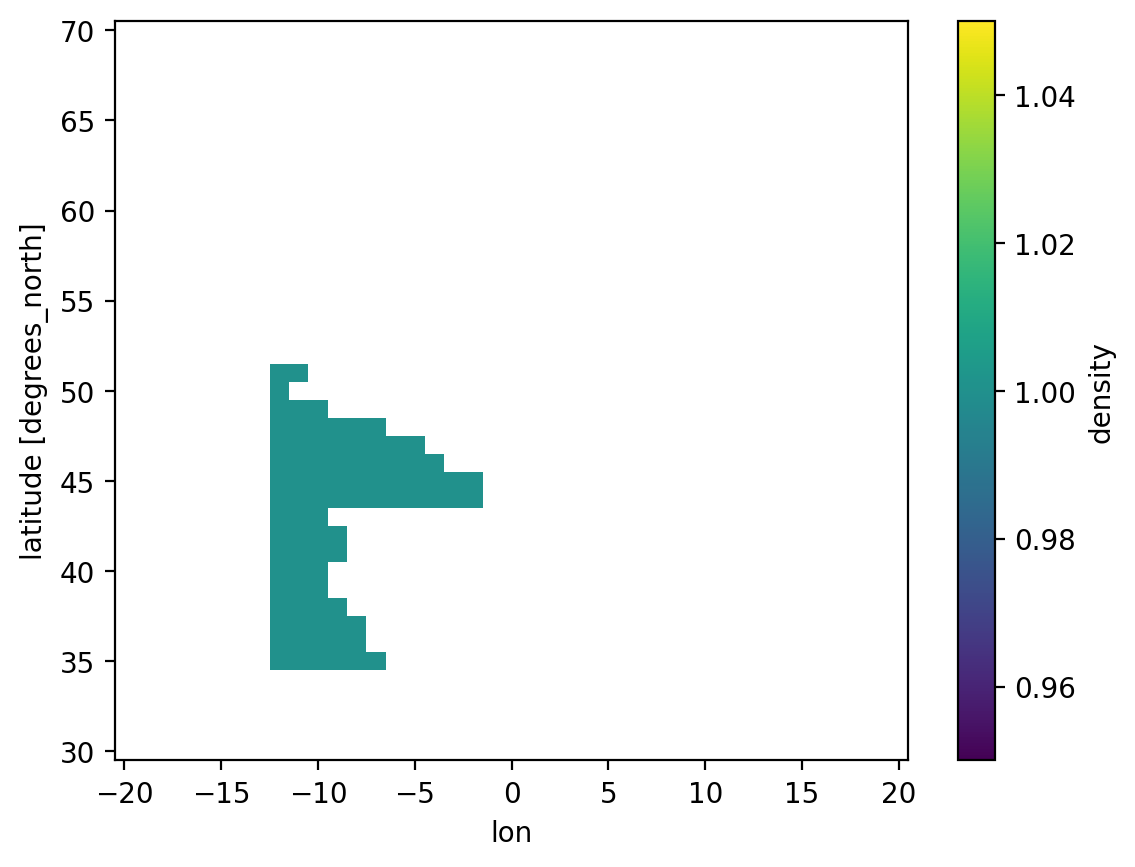

In [22]:
mask_EBB = slc.steric_masks_north_sea(DENS.density, 'EBB')
mask_EBB.plot()

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


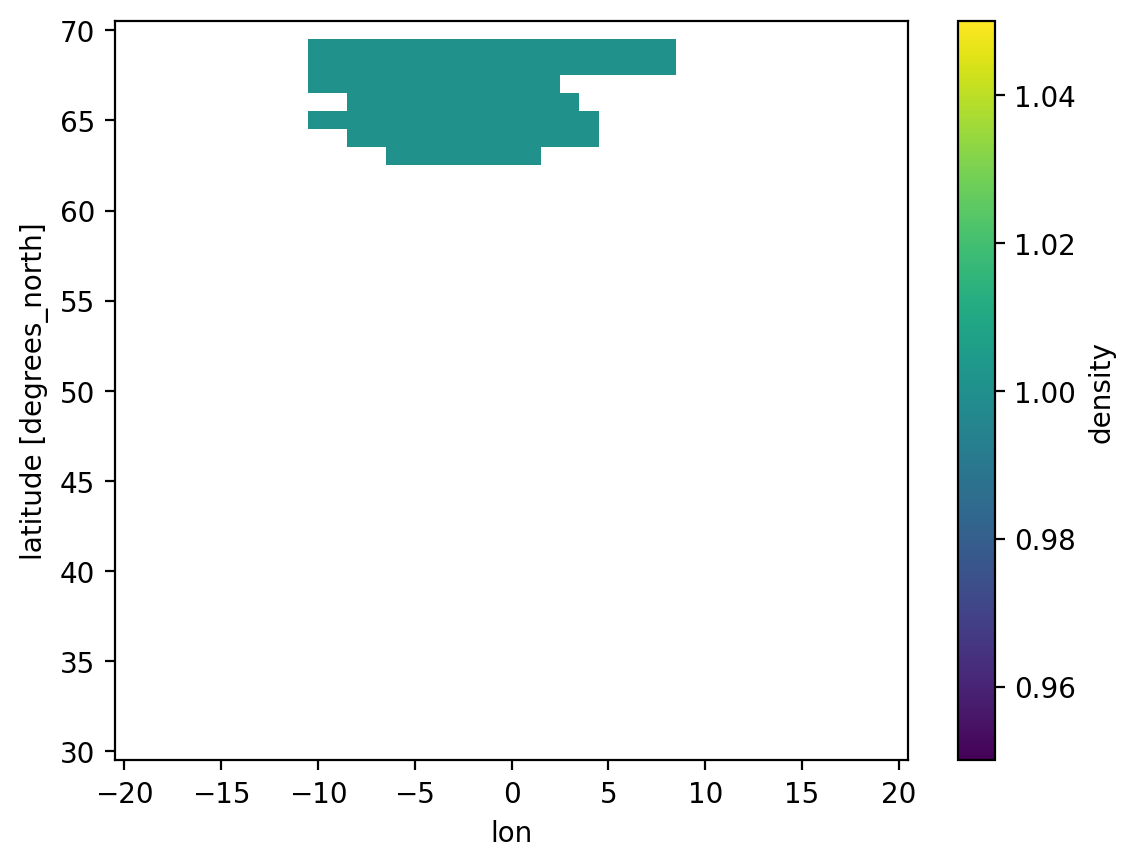

In [23]:
mask_NWS = slc.steric_masks_north_sea(DENS.density, 'NWS')
mask_NWS.plot()

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


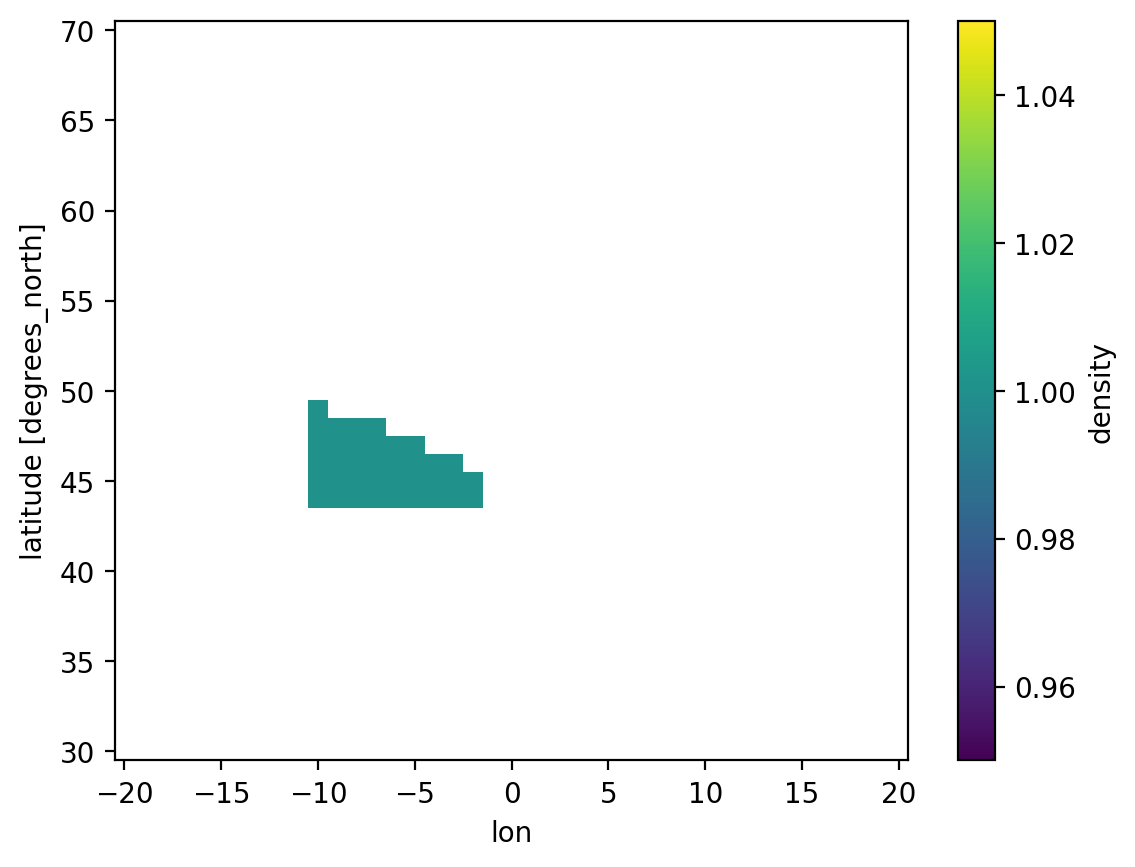

In [24]:
mask_BB = slc.steric_masks_north_sea(DENS.density, 'BB')
mask_BB.plot()

### Prepare a nicer figure of masks for talks

/opt/anaconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/anaconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/anaconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


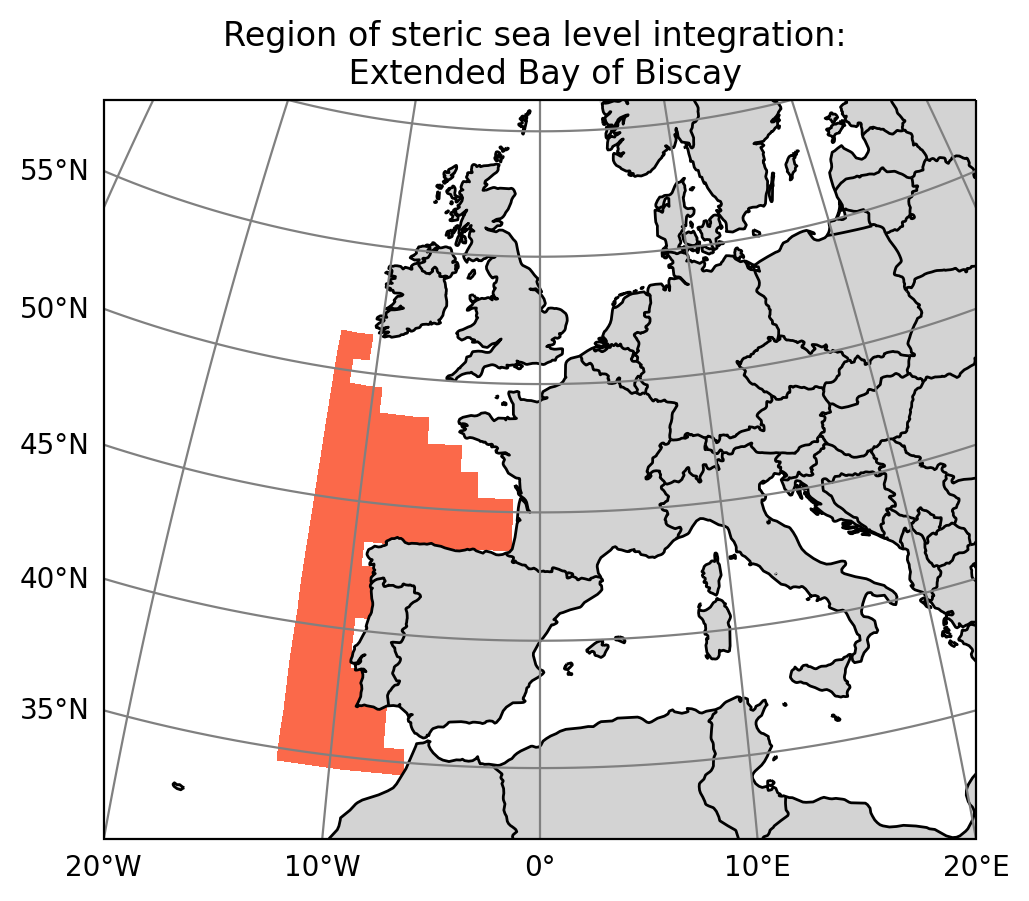

In [25]:
lon_min, lon_max, lat_min, lat_max = -20, 20, 30, 60

p = mask_EBB.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 45), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    add_colorbar=False,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)
p.axes.add_feature(cfeature.OCEAN, facecolor='white')
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
#cb = fig.colorbar()
#cb.remove()
plt.title('Region of steric sea level integration: \n Extended Bay of Biscay');

#plt.savefig('../figures/StericMaskRegionEBB.pdf', dpi=150)

### Compare steric sea level in the different regions

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


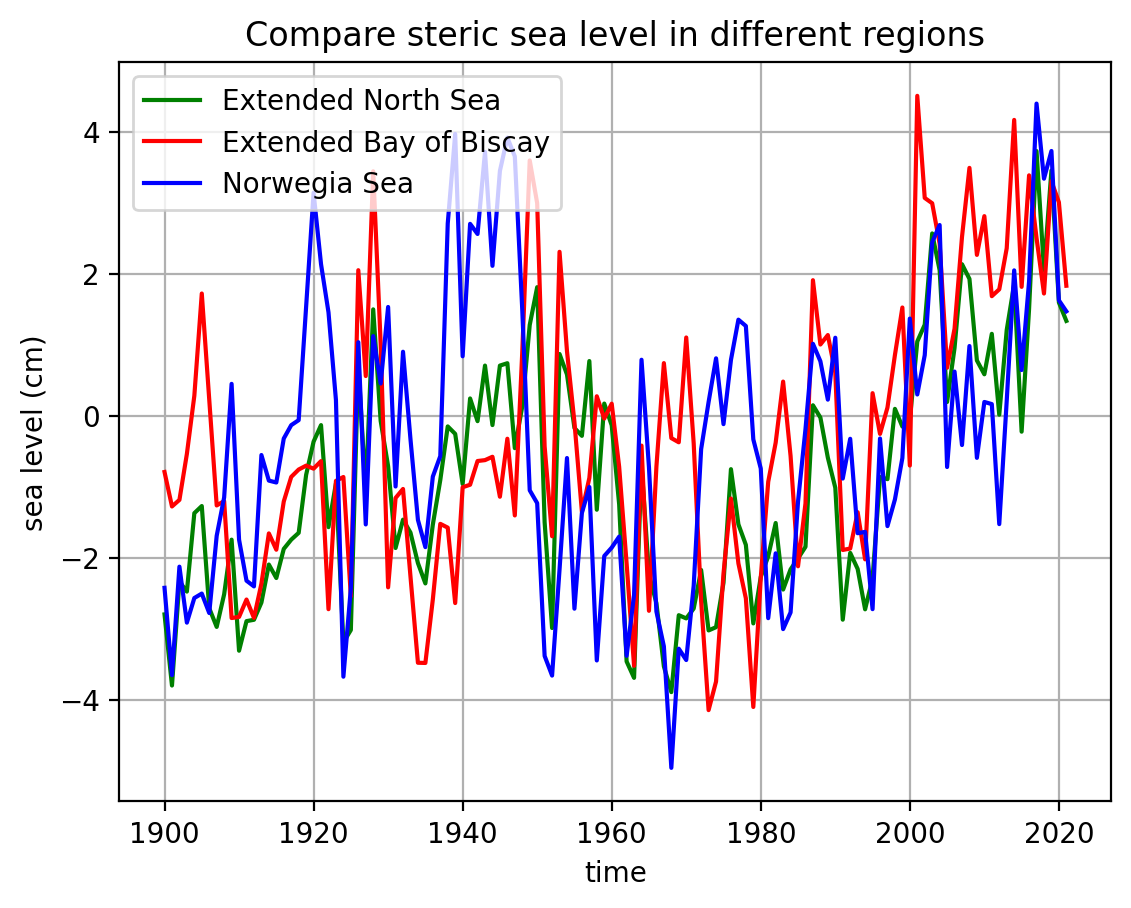

In [26]:
max_depth = 1000

StericSL_ENS_df = slc.StericSL('EN4_22', 'ENS', 0, max_depth, 0)
StericSL_EBB_df = slc.StericSL('EN4_22', 'EBB', 0, max_depth, 0)
StericSL_NWS_df = slc.StericSL('EN4_22', 'NWS', 0, max_depth, 0)

#Plot time series
fig, ax = plt.subplots()
ax.plot(StericSL_ENS_df, 'g-', label='Extended North Sea')
ax.plot(StericSL_EBB_df, 'r-', label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df, 'b-', label='Norwegia Sea')

#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric sea level in different regions')
ax.grid(True)
plt.legend(loc='upper left')

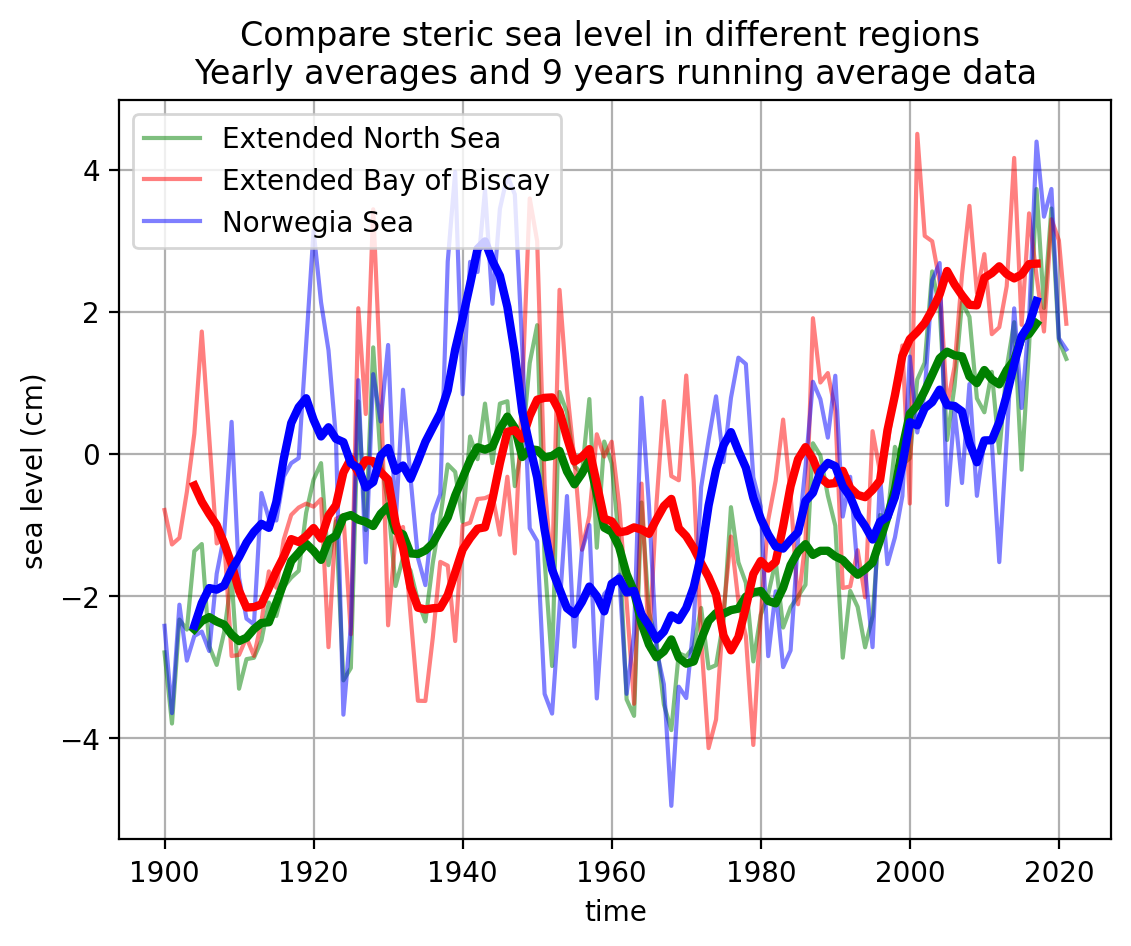

In [27]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(StericSL_ENS_df, 'g-', alpha=0.5, label='Extended North Sea')
ax.plot(StericSL_EBB_df, 'r-', alpha=0.5, label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df, 'b-', alpha=0.5, label='Norwegia Sea')

ax.plot(StericSL_ENS_df.rolling(9, center=True).mean(), 'g-', linewidth=3)
ax.plot(StericSL_EBB_df.rolling(9, center=True).mean(), 'r-', linewidth=3)
ax.plot(StericSL_NWS_df.rolling(9, center=True).mean(), 'b-', linewidth=3)

#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric sea level in different regions \n'+
         'Yearly averages and 9 years running average data')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/ComparisonStericDifferentRegions.pdf', dpi=150)

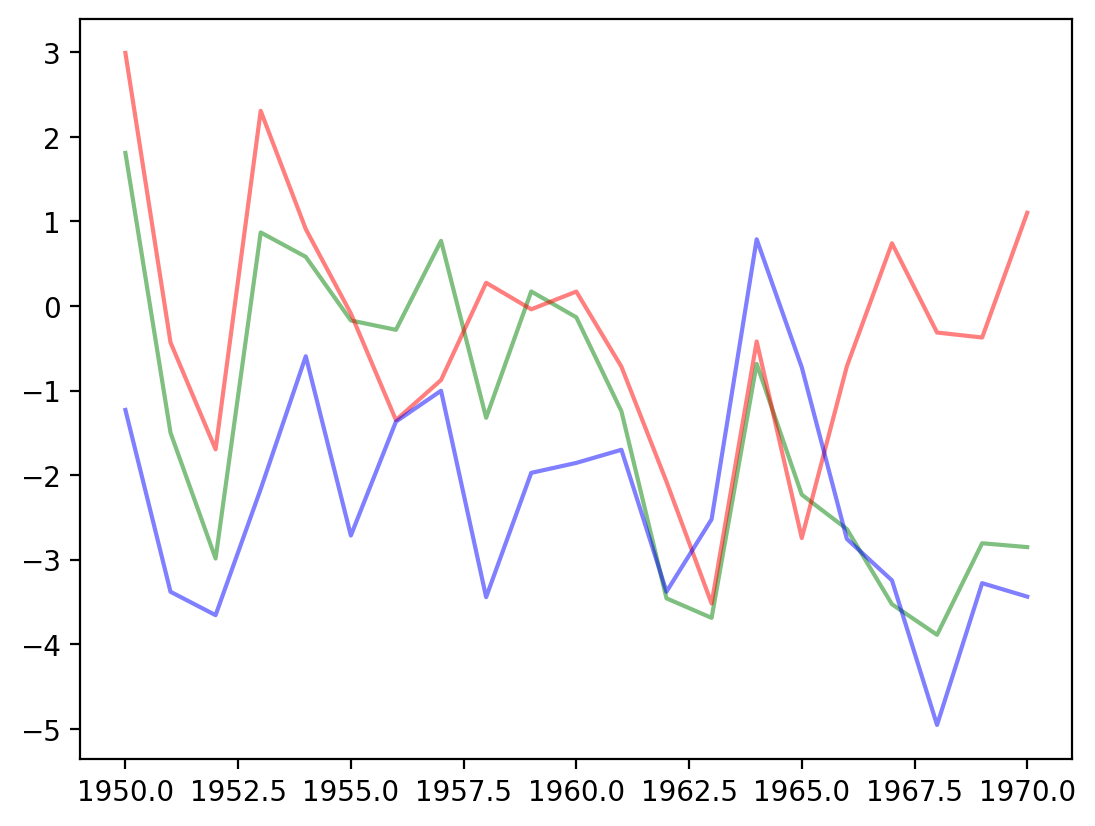

In [28]:
fig, ax = plt.subplots()
ax.plot(StericSL_ENS_df.loc[1950:1970], 'g-', alpha=0.5, label='Extended North Sea')
ax.plot(StericSL_EBB_df.loc[1950:1970], 'r-', alpha=0.5, label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df.loc[1950:1970], 'b-', alpha=0.5, label='Norwegia Sea')

### Compare with the global mean steric sea level anomaly from NOAA, Levitus

In [30]:
#Global mean total sea level anomaly (NOAA, Levitus)
# LevitusSL_df = slc.LevitusSL()
#LevitusSL_NA_df = slc.LevitusSL('NA')
# FredGlo_df = slc.contrib_frederikse2020_glob('Steric')


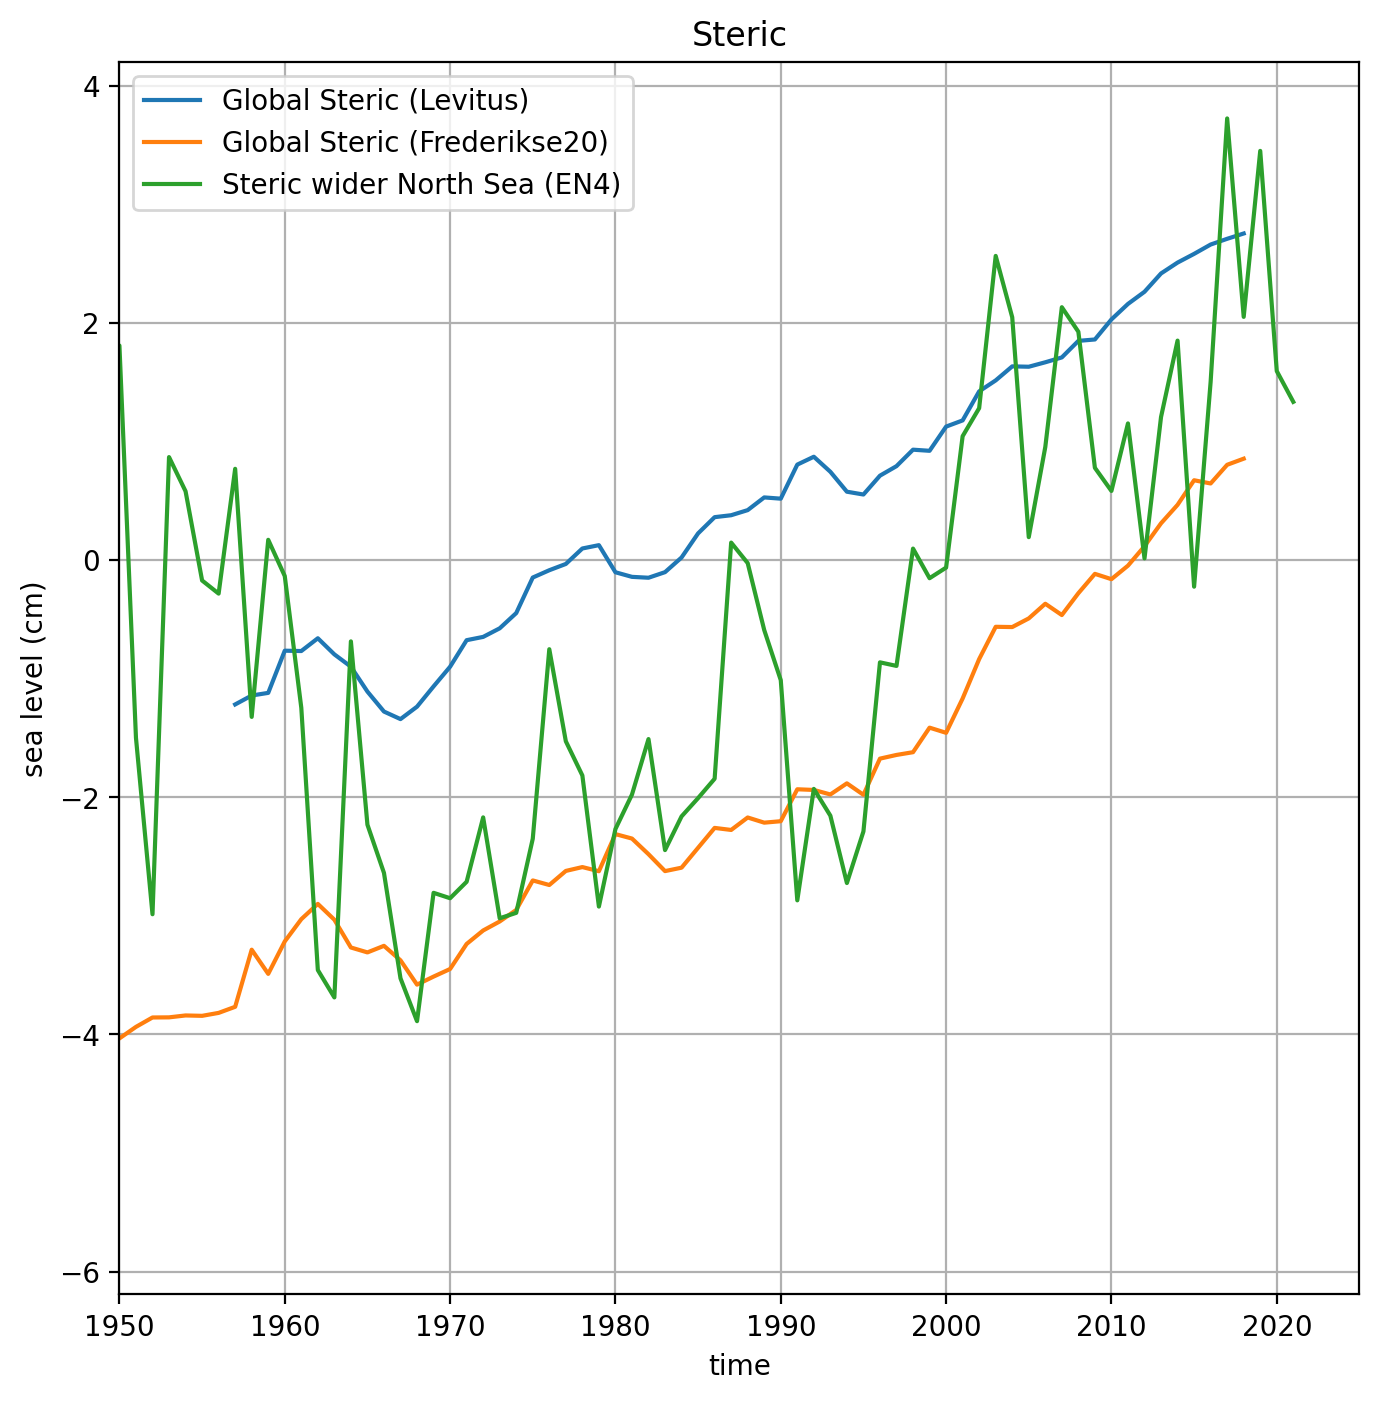

In [80]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(SeaLevel_df.height, 'r-') #From mm to cm
#ax.plot(StericSL_NS_df, 'b-')
ax.plot(LevitusSL_df, label='Global Steric (Levitus)')
ax.plot(FredGlo_df, label='Global Steric (Frederikse20)')
#ax.plot(LevitusSL_NA_df, label='North Atlantic Steric(Levitus)')
#ax.plot(StericSLreg_df, label='Steric Bay biscay (EN4)')
ax.plot(StericSL_ENS_df, label='Steric wider North Sea (EN4)')
#ax.set_aspect(1)
ax.set_xlim([1950,2025])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Steric')
plt.legend(loc='upper left')
ax.grid(True)

#plt.savefig('./Figures/ComparisonGloLocSteric', dpi=150)
#plt.savefig('~/Downloads/ComparisonGloLocSteric', dpi=150)

### Compare Levitus pentad data that stop in 2018 with the yearly data that goes on to 2019

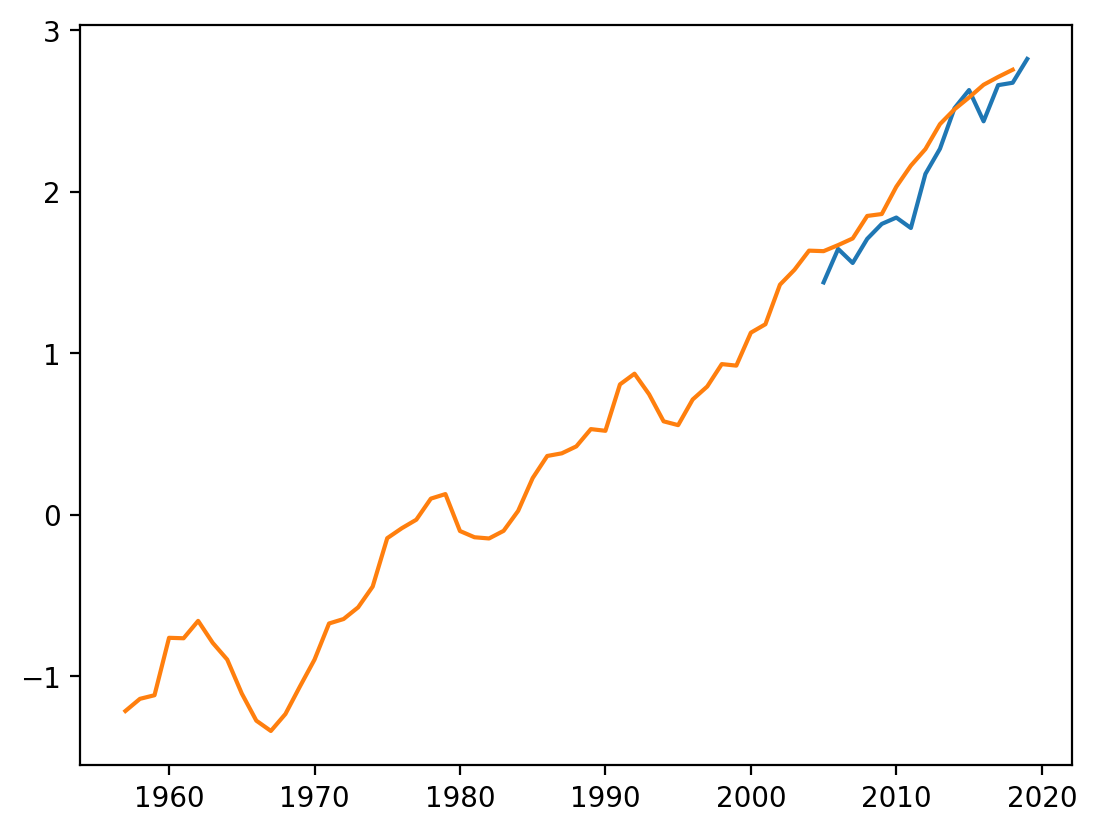

In [81]:
PATH_Data = '/Users/dewilebars/Data/'
Dir_LEV = PATH_Data + 'NOAA/'

Lev_ds = xr.open_dataset(Dir_LEV + \
                         'mean_total_steric_sea_level_anomaly_0-2000_yearly.nc', \
                         decode_times=False)
LevitusSL_y = Lev_ds.yearl_s_mm_WO.copy() / 10

# Convert from months since 1955 to years
LevitusSL_y['time'] = LevitusSL_y.time / 12 + 1955 - .5
LevitusSL_y['time'] = LevitusSL_y.time.astype(int)
LevitusSL_y_df = LevitusSL_y.to_dataframe()

plt.plot(LevitusSL_y_df.iloc[:-1])
plt.plot(LevitusSL_df)

Conclusion: The yearly data only adds one year so it is not worth it.

### Explore steric sea level from Cheng et al. 2017

In [82]:
# Read data preprocessed by DensityIAP_month2year.py
IAP_ds = xr.open_dataset(data_IAP+'Steric_IAP_2000m_yearly_1940_2019.nc')
IAP_ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, depth_std: 41, time: 80)
Coordinates:
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * depth_std  (depth_std) float32 1.0 5.0 10.0 20.0 ... 1.7e+03 1.8e+03 2e+03
  * time       (time) int64 1940 1941 1942 1943 1944 ... 2016 2017 2018 2019
Data variables:
    SSL_2000m  (time, lat, lon) float32 ...
    SSL_1500m  (time, lat, lon) float32 ...
    SSL_700m   (time, lat, lon) float32 ...
    SSL_300m   (time, lat, lon) float32 ...
    SSL_100m   (time, lat, lon) float32 ...

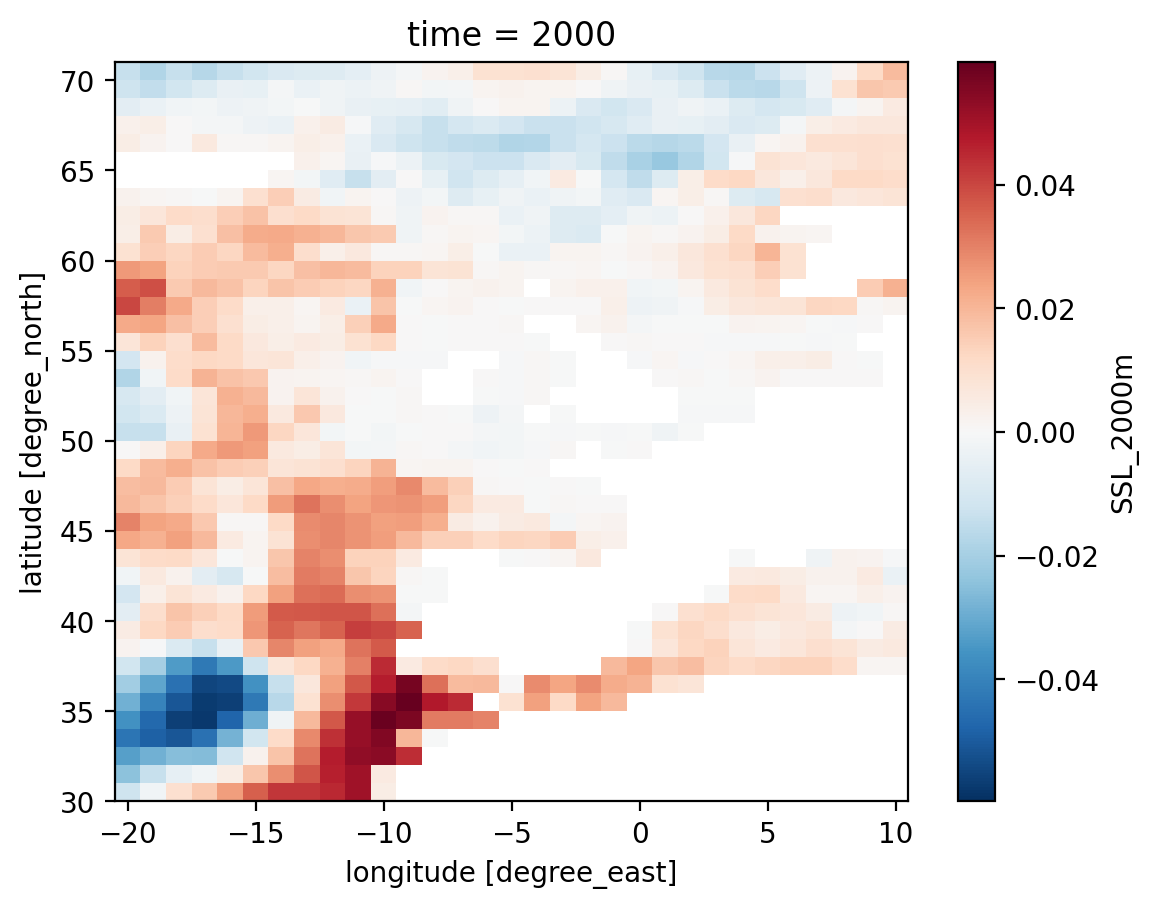

In [83]:
IAP_ds.SSL_2000m.sel(time=2000,lat=slice(30.5,70.5),lon=slice(-20,10)).plot()

It is not possible to have the same method as used in EN4 with the steric data provided by IAP. For EN4 I downloaded the salinity and temperature fields and then computed the 3D steric expansion at each vertical level. This allowed to average steric sea level over larger areas.

It would be more consistent to do the same here with the IAP data. It also gives me a better handle on the exact way the expansion is computed.

In the meantime the Extended Bay of Biscay and Norwegian Sea regions can be used.

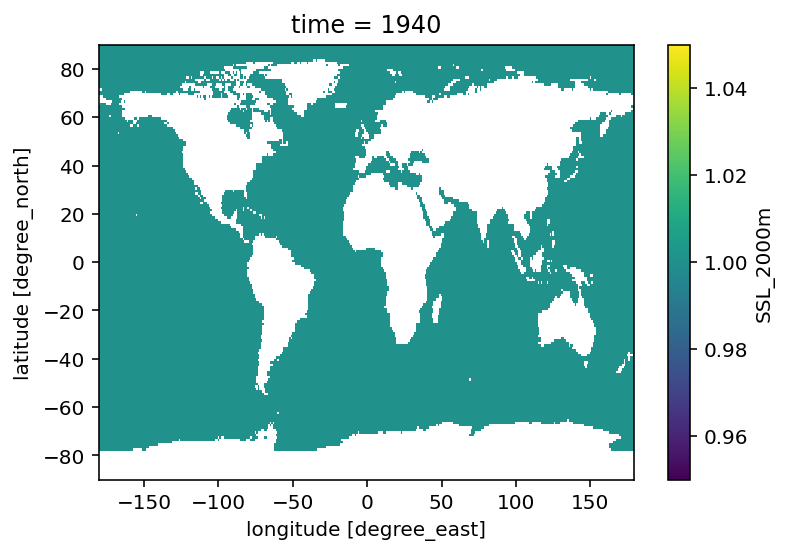

In [29]:
mask = xr.where(np.isnan(IAP_ds.SSL_2000m[0,:,:]), np.nan, 1)
mask.plot()

In [23]:
def steric_masks_IAP2D(da, mask_name):
    if mask_name == 'ENS':
        # Extended North Sea mask
        lat = np.array(da.lat)
        lon = np.array(da.lon)
        LatAr = np.repeat(lat[:,np.newaxis], len(lon), 1)
        LatAr = xr.DataArray(LatAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})
        LonAr = np.repeat(lon[np.newaxis,:], len(lat), 0)
        LonAr = xr.DataArray(LonAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})

        mask_med = xr.where(np.isnan(da[0,:,:]), np.nan, 1)
        mask_med1 = mask_med.where((LonAr >= -8) & (LatAr <= 42) )
        mask_med1 = xr.where(np.isnan(mask_med1), 1, np.nan)
        mask_med2 = mask_med.where((LonAr >= 1) & (LatAr <= 48) )
        mask_med2 = xr.where(np.isnan(mask_med2), 1, np.nan)
        mask_med = mask_med * mask_med1 * mask_med2

        mask = xr.where(np.isnan(da[0,:,:]), np.nan, 1)
        mask = mask.where(mask.lon <= 7)
        mask = mask.where(mask.lon >= -16)
        mask = mask.where(mask.lat <= 69) #Normal value: 60 or 69
        mask = mask.where(mask.lat >= 33)
        mask = mask * mask_med
    del mask['time']
    return mask

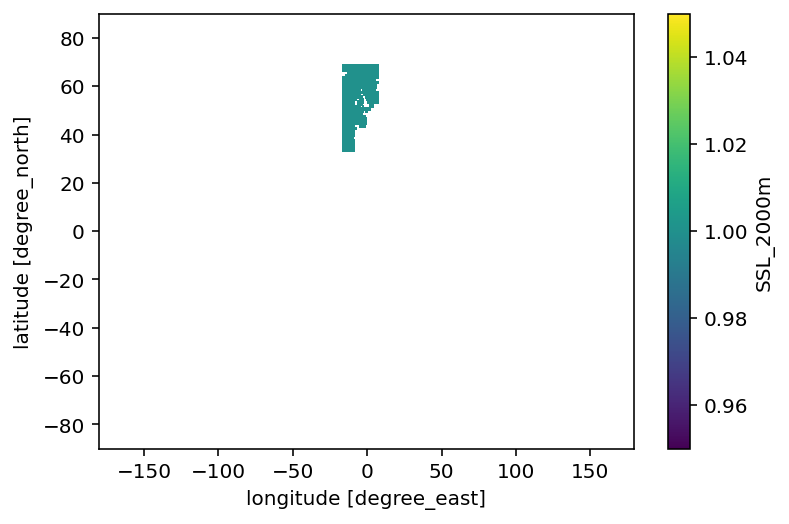

In [24]:
mask_ENS = steric_masks_IAP2D(IAP_ds.SSL_2000m, 'ENS')
mask_ENS.plot()

### Look into the 3D density files computed from IAP (Cheng et al. 2017)

In [50]:
steric3D_IAP = xr.open_mfdataset(data_steric3D_IAP+'density_teos10_iap_*.nc')

In [51]:
steric3D_IAP.depth

<xarray.DataArray 'depth' (depth: 41)>
array([1.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 3.0e+01, 4.0e+01, 5.0e+01, 6.0e+01,
       7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 1.2e+02, 1.4e+02, 1.6e+02, 1.8e+02,
       2.0e+02, 2.5e+02, 3.0e+02, 3.5e+02, 4.0e+02, 4.5e+02, 5.0e+02, 5.5e+02,
       6.0e+02, 6.5e+02, 7.0e+02, 7.5e+02, 8.0e+02, 8.5e+02, 9.0e+02, 1.0e+03,
       1.1e+03, 1.2e+03, 1.3e+03, 1.4e+03, 1.5e+03, 1.6e+03, 1.7e+03, 1.8e+03,
       2.0e+03], dtype=float32)
Coordinates:
  * depth    (depth) float32 1.0 5.0 10.0 20.0 ... 1.6e+03 1.7e+03 1.8e+03 2e+03
Attributes:
    long_name:      standard depth
    units:          m
    standard_name:  depth_std

In [68]:
steric_ENS_IAP = slc.StericSL(0, 1000, 'ENS', 'IAP', 0).rename(columns={'Steric': 'ENS'})
steric_EBB_IAP = slc.StericSL(0, 1000, 'EBB', 'IAP', 0).rename(columns={'Steric': 'EBB'})
steric_NWS_IAP = slc.StericSL(0, 1000, 'NWS', 'IAP', 0).rename(columns={'Steric': 'NWS'})


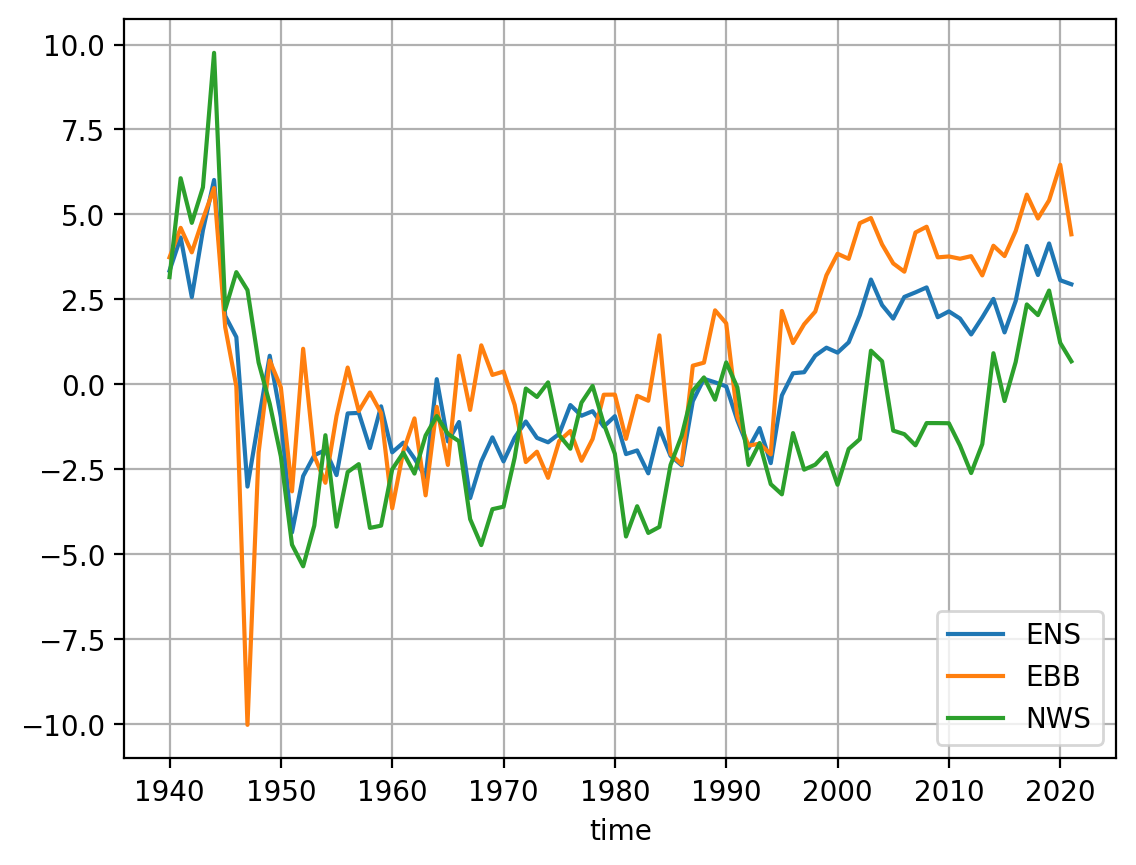

In [70]:
fig, ax = plt.subplots()

steric_ENS_IAP.plot(ax=ax)
steric_EBB_IAP.plot(ax=ax)
steric_NWS_IAP.plot(ax=ax)

ax.grid(True)
plt.legend()

In [65]:
steric_ENS_IAP

,Steric
time,
1940,3.343330
1941,4.322763
1942,2.567167
1943,4.534210
1944,6.014398
...,...
2017,4.072585
2018,3.216744
2019,4.146015


### Compare steric sea level from IAP and from EN4

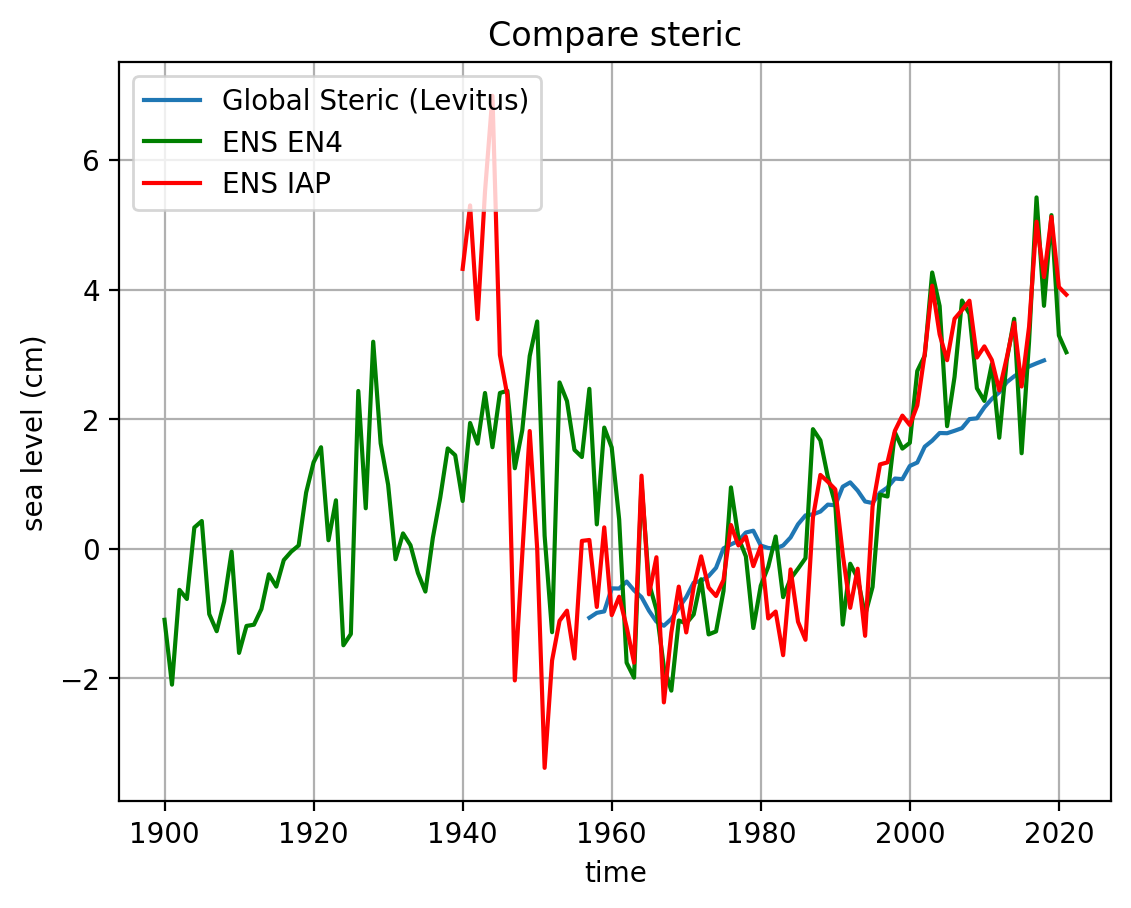

In [57]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(LevitusSL_df - LevitusSL_df.loc[970:2000].mean(), label='Global Steric (Levitus)')
ax.plot(StericSL_ENS_df - StericSL_ENS_df.loc[1970:2000].mean(), 'g-', label='ENS EN4')
ax.plot(steric_ENS_IAP - steric_ENS_IAP.loc[1970:2000].mean(), 'r-', label='ENS IAP')
#ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')
#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/Steric_EN4_IAP_ArroundNorthSea_top2000m.pdf', dpi=150)

The IAP data has a strange drop of steric sea level in the 1940s. This drop is not found in the data nor in EN4.

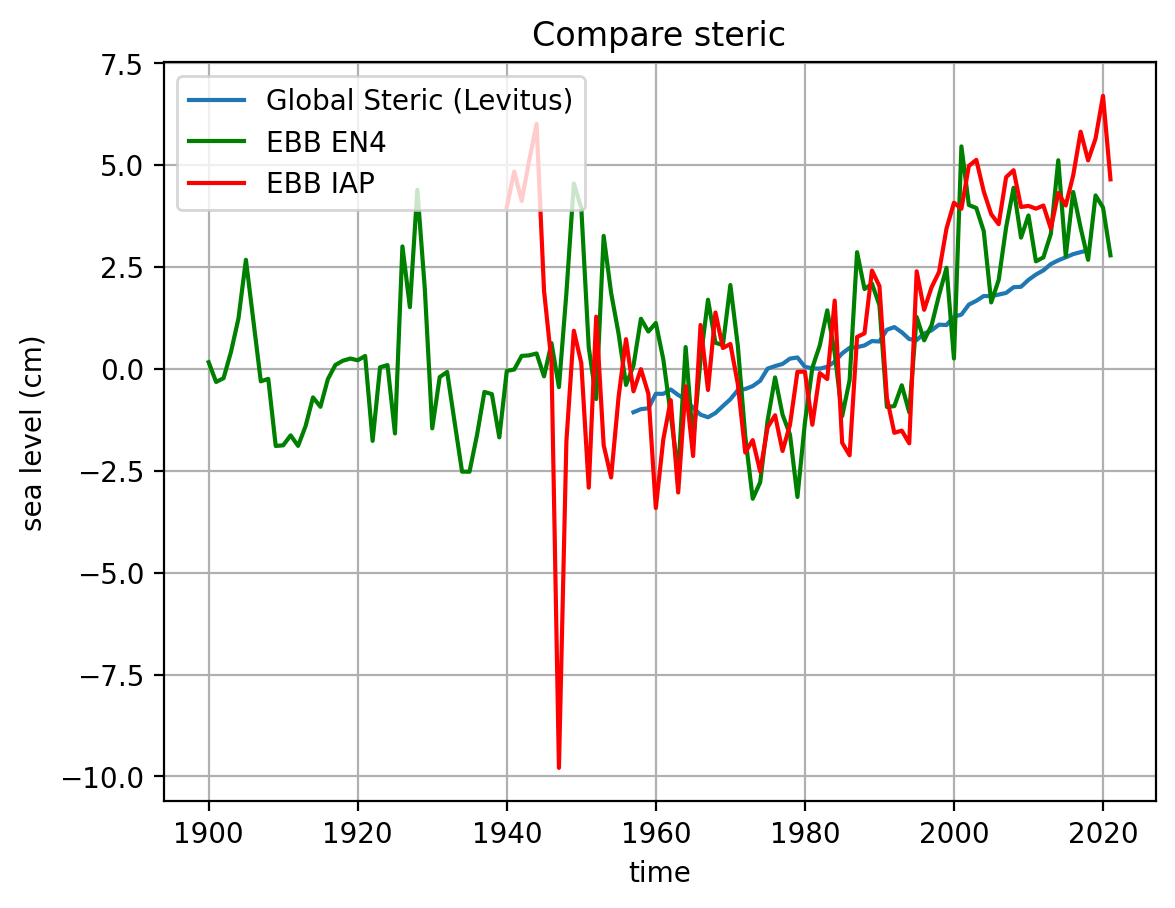

In [71]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(LevitusSL_df - LevitusSL_df.loc[970:2000].mean(), label='Global Steric (Levitus)')
ax.plot(StericSL_EBB_df - StericSL_EBB_df.loc[1970:2000].mean(), 'g-', label='EBB EN4')
ax.plot(steric_EBB_IAP - steric_EBB_IAP.loc[1970:2000].mean(), 'r-', label='EBB IAP')
#ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')
#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/Steric_EN4_IAP_ArroundNorthSea_top2000m.pdf', dpi=150)